#Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Importing dataset

In [ ]:
visits = pd.read_excel('exemplary_data.xlsx', sheet_name='visits')
visits

,Data,godzina,Wizyty_all
0,2014-10-01,0,1589
1,2014-10-01,1,658
2,2014-10-01,2,299
3,2014-10-01,3,211
4,2014-10-01,4,257
...,...,...,...
2203,2014-12-31,19,2243
2204,2014-12-31,20,1844
2205,2014-12-31,21,1680
2206,2014-12-31,22,1538


In [ ]:
spots = pd.read_excel('exemplary_data.xlsx', sheet_name='spots')
spots

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.000000
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.000000
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30,0.000000
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30,0.000000
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.000000
...,...,...,...,...,...,...,...,...,...,...
2202,TVN Pakiet Tematyczny,kuchnia.tv,2014-11-23,24:32:15,Night,After,PRZEZ DZIURKE OD SERA /PROG.PORAD.POL./,Middle,30,0.000000
2203,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-23,24:46:21,Night,Between,COUGAR TOWN MIASTO KOCIC /SER.KOM.USA/,Middle,30,0.000000
2204,Polsat Pakiet Tematyczny,ATM Rozrywka,2014-11-23,25:11:09,Night,Between,SYNOWIE /SER.KOM.POL./,Middle,30,0.000000
2205,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-23,25:26:59,Night,After,ZLO W GENACH /SER.DOK.USA/,Middle,30,0.525207


#Extracting same time range

Lets see what time range both datasets present

In [ ]:
visits.iloc[0,:]

Data          2014-10-01 00:00:00
godzina                         0
Wizyty_all                   1589
Name: 0, dtype: object

In [ ]:
visits.iloc[-1,:]

Data          2014-12-31 00:00:00
godzina                        23
Wizyty_all                   1049
Name: 2207, dtype: object

visits includes data from full three months: October, November, December

In [ ]:
spots.iloc[0,:]

Campaign Channel                                          TVN Pakiet Tematyczny
AGB Channel                                                             FoxLife
Date                                                        2014-11-10 00:00:00
Time                                                                   06:10:25
Timeband                                                                    Day
BreakType (Block type)                                                  Between
Title                                        ZONA DLA MILIONERA /PROG.ROZR.USA/
Position Type in the block of commercials                                Middle
Commercial length                                                            30
GRP                                                                           0
Name: 0, dtype: object

In [ ]:
spots.iloc[-1,:]

Campaign Channel                                                                TVN
AGB Channel                                                                     TVN
Date                                                            2014-11-23 00:00:00
Time                                                                       25:30:24
Timeband                                                                      Night
BreakType (Block type)                                                      Between
Title                                        KUCHENNE REWOLUCJE /REALITY SHOW POL./
Position Type in the block of commercials                      Second / Penultimate
Commercial length                                                                30
GRP                                                                        0.190529
Name: 2206, dtype: object

spots dataset includes data from 10.11.2014 6 a.m. till 23.11.2014 2 a.m.

Since we want to check impact of spots on ratings I will drop all rows before 10.11.2014 6 a.m. and all rows after 23.11.2014 2 a.m. from visits dataset.

For faster data preprocessing I've decided to cut mentioned above rows in excel, import new visits dataset and overwrite visits variable.

In [ ]:
visits = pd.read_excel('visits.xlsx')
visits

,Data,godzina,Wizyty_all
0,2014-11-10,6,1070
1,2014-11-10,7,3086
2,2014-11-10,8,5989
3,2014-11-10,9,11506
4,2014-11-10,10,9680
...,...,...,...
304,2014-11-22,22,5350
305,2014-11-22,23,3989
306,2014-11-23,0,2356
307,2014-11-23,1,991


#Data preprocessing

I want to merge datasets into one dataset. To find out whether an advertising spot has any impact on the ratings first I need to match visits and spots datasets by exact time

##Reassigning time

I've noticed that Date column in spots dataset shows 25 instead of 1 a.m. and 24 instead of 0 a.m. I will change it with apply function

In [ ]:
type(spots['Time'][0])

str

As we could guess it's a string type

In [ ]:
spots['Time'] = spots['Time'].apply(lambda x: '01%s' % (x[2:]) if x[0:2]=='25' else x)
spots['Time'] = spots['Time'].apply(lambda x: '00%s' % (x[2:]) if x[0:2]=='24' else x)
spots.tail(10)

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP
2197,TVN Pakiet Tematyczny,VH1 Europe,2014-11-23,23:47:52,Night,Between,VH1 HITS /PROGR.MUZ.W.BRYT./,Middle,30,0.000000
2198,TVN Pakiet Tematyczny,FoxLife,2014-11-23,23:47:53,Night,Before,POKOJOWKI Z BEVERLY HILLS /SER.OBYCZ.USA/,Middle,30,0.000000
2199,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-23,00:13:27,Night,Between,TELEDYSKI,Middle,30,0.000000
2200,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-23,00:27:49,Night,After,MROCZNE UMYSLY /SER.DOK.USA/,Middle,30,0.000000
2201,TVN Pakiet Tematyczny,FoxLife,2014-11-23,00:29:07,Night,Between,POKOJOWKI Z BEVERLY HILLS /SER.OBYCZ.USA/,Middle,30,0.000000
2202,TVN Pakiet Tematyczny,kuchnia.tv,2014-11-23,00:32:15,Night,After,PRZEZ DZIURKE OD SERA /PROG.PORAD.POL./,Middle,30,0.000000
2203,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-23,00:46:21,Night,Between,COUGAR TOWN MIASTO KOCIC /SER.KOM.USA/,Middle,30,0.000000
2204,Polsat Pakiet Tematyczny,ATM Rozrywka,2014-11-23,01:11:09,Night,Between,SYNOWIE /SER.KOM.POL./,Middle,30,0.000000
2205,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-23,01:26:59,Night,After,ZLO W GENACH /SER.DOK.USA/,Middle,30,0.525207
2206,TVN,TVN,2014-11-23,01:30:24,Night,Between,KUCHENNE REWOLUCJE /REALITY SHOW POL./,Second / Penultimate,30,0.190529


##Reassigning dates

Now I have to take care of dates. In every 24 and 01 hour the day haven't changed to next day. I've tried multiple functions with apply() but I find out that pandas bug occurs. That's why I will create 2 separate columns 'actualHour' and 'dayOfMonth'

First I will change datetime type from Date column into string type.

In [ ]:
spots['Date'][0]

Timestamp('2014-11-10 00:00:00')

In [ ]:
from datetime import datetime, timedelta
spots['Date'] = spots['Date'].apply(lambda x: datetime.strftime(x,'%Y-%m-%d'))

In [ ]:
spots['Date'][2206]

'2014-11-23'

In [ ]:
spots['Time'][0]

'06:10:25'

In [ ]:
spots['actualHour'] = spots['Time'].apply(lambda x: x[:2]) 
spots['dayOfMonth'] = spots['Date'].apply(lambda x: x[-2:])

I will turn string type into int type in actualHour and dayOfMonth columns

In [ ]:
spots['actualHour'] = spots['actualHour'].apply(lambda x: int(x))
spots['dayOfMonth'] = spots['dayOfMonth'].apply(lambda x: int(x))

In [ ]:
type(spots['actualHour'][0])

numpy.int64

In [ ]:
type(spots['dayOfMonth'][0])

numpy.int64

In [ ]:
spots.head()

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.0,6,10
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.0,6,10
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30,0.0,6,10
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30,0.0,6,10
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.0,6,10


I have to reassign every date which is attached to 0 or 1 hour. Every mentioned day should be greater by 1

In [ ]:
# spots['Date'] = spots[['Date','Time']].apply(lambda x: x[0]+timedelta(days=1) if x[1] == 0 or x[1] == 1 else x[0])

In [ ]:
dayOfMonth = spots['dayOfMonth']
actualHour = spots['actualHour']

In [ ]:
dayOfMonth

0       10
1       10
2       10
3       10
4       10
        ..
2202    23
2203    23
2204    23
2205    23
2206    23
Name: dayOfMonth, Length: 2207, dtype: int64

In [ ]:
actualHour

0       6
1       6
2       6
3       6
4       6
       ..
2202    0
2203    0
2204    1
2205    1
2206    1
Name: actualHour, Length: 2207, dtype: int64

In [ ]:
reassignedDate = []

for i in range(len(dayOfMonth)):
  if actualHour[i] == 1 or actualHour[i] == 0:
    reassignedDate.append(dayOfMonth[i]+1)
  else:
    reassignedDate.append(dayOfMonth[i])

In [ ]:
len(reassignedDate)

2207

In [ ]:
spots['dayOfMonth'] = reassignedDate

In [ ]:
spots

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.000000,6,10
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.000000,6,10
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30,0.000000,6,10
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30,0.000000,6,10
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.000000,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...
2202,TVN Pakiet Tematyczny,kuchnia.tv,2014-11-23,00:32:15,Night,After,PRZEZ DZIURKE OD SERA /PROG.PORAD.POL./,Middle,30,0.000000,0,24
2203,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-23,00:46:21,Night,Between,COUGAR TOWN MIASTO KOCIC /SER.KOM.USA/,Middle,30,0.000000,0,24
2204,Polsat Pakiet Tematyczny,ATM Rozrywka,2014-11-23,01:11:09,Night,Between,SYNOWIE /SER.KOM.POL./,Middle,30,0.000000,1,24
2205,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-23,01:26:59,Night,After,ZLO W GENACH /SER.DOK.USA/,Middle,30,0.525207,1,24


Now I will create new column in spots dataset named 'roundTime' which will consist of hours only. But to be more accurate I will ascribe to the exact time the whole hour that is the closest one. For example 01:12:23 will become 1 but 01:47:23 will become 2.

In [ ]:
def roundTime(time):
  if int(time[3:5]) < 30:
    return int(time[:2])
  else:
    return int(time[:2])+1

In [ ]:
spots['roundTime'] = spots['Time'].apply(roundTime)

In [ ]:
spots.head()

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth,roundTime
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.0,6,10,6
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.0,6,10,6
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30,0.0,6,10,6
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30,0.0,6,10,6
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.0,6,10,7


##Additional time reassigning

We have to remember that 23 has changed into 24 and what we need is 0.

In [ ]:
spots['roundTime'] = spots['roundTime'].apply(lambda x: 0 if x == 24 else x)

##Datetime recreation

###Spots dataset

Till I want to merge both datasets visit and spots by date and hour I need to recreate date column in spots data set

In [ ]:
spots.tail()

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth,roundTime
2202,TVN Pakiet Tematyczny,kuchnia.tv,2014-11-23,00:32:15,Night,After,PRZEZ DZIURKE OD SERA /PROG.PORAD.POL./,Middle,30,0.000000,0,24,1
2203,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-23,00:46:21,Night,Between,COUGAR TOWN MIASTO KOCIC /SER.KOM.USA/,Middle,30,0.000000,0,24,1
2204,Polsat Pakiet Tematyczny,ATM Rozrywka,2014-11-23,01:11:09,Night,Between,SYNOWIE /SER.KOM.POL./,Middle,30,0.000000,1,24,1
2205,TVN Pakiet Tematyczny,Investigation Discovery,2014-11-23,01:26:59,Night,After,ZLO W GENACH /SER.DOK.USA/,Middle,30,0.525207,1,24,1
2206,TVN,TVN,2014-11-23,01:30:24,Night,Between,KUCHENNE REWOLUCJE /REALITY SHOW POL./,Second / Penultimate,30,0.190529,1,24,2


In [ ]:
dayOfMonth

0       10
1       10
2       10
3       10
4       10
        ..
2202    24
2203    24
2204    24
2205    24
2206    24
Name: dayOfMonth, Length: 2207, dtype: int64

In [ ]:
date = spots['Date']
date

0       2014-11-10
1       2014-11-10
2       2014-11-10
3       2014-11-10
4       2014-11-10
           ...    
2202    2014-11-23
2203    2014-11-23
2204    2014-11-23
2205    2014-11-23
2206    2014-11-23
Name: Date, Length: 2207, dtype: object

In [ ]:
date[2][:8]

'2014-11-'

In [ ]:
time = spots['roundTime']
time

0       6
1       6
2       6
3       6
4       7
       ..
2202    1
2203    1
2204    1
2205    1
2206    2
Name: roundTime, Length: 2207, dtype: int64

First I will create proper string

In [ ]:
dateReassigned = []

for i in range(len(dayOfMonth)):
    front = date[i][:8]
    back = str(dayOfMonth[i])
    yearMonthDay = '%s%s' % (front,back)
    hour = str(time[i])
    dateReassigned.append('%s %s:00:00' % (yearMonthDay,hour))

In [ ]:
len(dateReassigned)

2207

In [ ]:
dateReassigned[0]

'2014-11-10 6:00:00'

Finally I can change type into datetime and add column to spots datasets

In [ ]:
from datetime import datetime, timedelta

dateReassigned_datetime = []

for i in range(len(dateReassigned)):
  dateReassigned_datetime.append(datetime.strptime(dateReassigned[i], '%Y-%m-%d %H:%M:%S'))
  # datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

In [ ]:
dateReassigned_datetime[0]

datetime.datetime(2014, 11, 10, 6, 0)

In [ ]:
len(dateReassigned_datetime)

2207

In [ ]:
spots['dateReassigned_datetime'] = dateReassigned_datetime

In [ ]:
spots.head()

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth,roundTime,dateReassigned_datetime
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.0,6,10,7,2014-11-10 07:00:00


In [ ]:
spots['dateReassigned_datetime'][0]

Timestamp('2014-11-10 06:00:00')

###Visits dataset

Now I will create date_datetime column in visits dataset on the same principles as above

In [ ]:
visits.head()

,Data,godzina,Wizyty_all
0,2014-11-10,6,1070
1,2014-11-10,7,3086
2,2014-11-10,8,5989
3,2014-11-10,9,11506
4,2014-11-10,10,9680


In [ ]:
date2 = visits['Data']
time2 = visits['godzina']

In [ ]:
date2[0]

Timestamp('2014-11-10 00:00:00')

In [ ]:
type(time2[0])

numpy.int64

In [ ]:
date_datetime = []

for i in range(len(date2)):
  date_datetime.append(date2[i]+timedelta(hours=int(time2[i])))

In [ ]:
date_datetime[0]

Timestamp('2014-11-10 06:00:00')

In [ ]:
visits['date_datetime'] = date_datetime

##Merging datasets

I will merge both datasets on date_datetime in visits dataset and dateReassigned_datetime in spots dataset

In [ ]:
visits.head()

,Data,godzina,Wizyty_all,date_datetime
0,2014-11-10,6,1070,2014-11-10 06:00:00
1,2014-11-10,7,3086,2014-11-10 07:00:00
2,2014-11-10,8,5989,2014-11-10 08:00:00
3,2014-11-10,9,11506,2014-11-10 09:00:00
4,2014-11-10,10,9680,2014-11-10 10:00:00


In [ ]:
spots.head()

,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth,roundTime,dateReassigned_datetime
0,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
1,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
2,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
3,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30,0.0,6,10,6,2014-11-10 06:00:00
4,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30,0.0,6,10,7,2014-11-10 07:00:00


In [ ]:
data = pd.merge(left=visits, right=spots, how='left', left_on = ['date_datetime'], right_on= ['dateReassigned_datetime'])
data

,Data,godzina,Wizyty_all,date_datetime,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth,roundTime,dateReassigned_datetime
0,2014-11-10,6,1070,2014-11-10 06:00:00,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
1,2014-11-10,6,1070,2014-11-10 06:00:00,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
2,2014-11-10,6,1070,2014-11-10 06:00:00,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
3,2014-11-10,6,1070,2014-11-10 06:00:00,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
4,2014-11-10,7,3086,2014-11-10 07:00:00,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30.0,0.000000,6.0,10.0,7.0,2014-11-10 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073,2014-11-23,1,991,2014-11-23 01:00:00,Polsat Pakiet Tematyczny,Kino Polska,2014-11-22,00:31:57,Night,Between,07 ZGLOS SIE /SER.KRYM.POL./,Middle,30.0,0.000000,0.0,23.0,1.0,2014-11-23 01:00:00
2074,2014-11-23,1,991,2014-11-23 01:00:00,TVN Pakiet Tematyczny,TVN Style,2014-11-22,01:19:40,Night,Between,SEKS NA MILION SPOSOBOW /SER.DOK.FRA./,Middle,30.0,0.478713,1.0,23.0,1.0,2014-11-23 01:00:00
2075,2014-11-23,1,991,2014-11-23 01:00:00,TVN Pakiet Tematyczny,Domo,2014-11-22,01:24:35,Night,After,POUZYWAJMY SOBIE HISTORIA POLSKIEGO WZORNICTWA...,Middle,30.0,0.000000,1.0,23.0,1.0,2014-11-23 01:00:00
2076,2014-11-23,1,991,2014-11-23 01:00:00,TVN Pakiet Tematyczny,AXN,2014-11-22,01:29:18,Night,Between,PROFIL /SER.SENS.FRAN./,Middle,30.0,0.190379,1.0,23.0,1.0,2014-11-23 01:00:00


##Dataset cleaning

###Drop NaN

Dropping NaN values

In [ ]:
data.isnull().sum()

Data                                         0
godzina                                      0
Wizyty_all                                   0
date_datetime                                0
Campaign Channel                             8
AGB Channel                                  8
Date                                         8
Time                                         8
Timeband                                     8
BreakType (Block type)                       8
Title                                        8
Position Type in the block of commercials    8
Commercial length                            8
GRP                                          8
actualHour                                   8
dayOfMonth                                   8
roundTime                                    8
dateReassigned_datetime                      8
dtype: int64

In [ ]:
data = data.dropna()

I have to reser indexes

###Reset index

In [ ]:
data = data.reset_index(drop=True)

I will extract only columns that are significant for further data processing

###Significant data

In [ ]:
data_rt_wall = data[['date_datetime','roundTime','Wizyty_all']]

In [ ]:
data_rt_wall

,date_datetime,roundTime,Wizyty_all
0,2014-11-10 06:00:00,6.0,1070
1,2014-11-10 06:00:00,6.0,1070
2,2014-11-10 06:00:00,6.0,1070
3,2014-11-10 06:00:00,6.0,1070
4,2014-11-10 07:00:00,7.0,3086
...,...,...,...
2065,2014-11-23 00:00:00,0.0,2356
2066,2014-11-23 01:00:00,1.0,991
2067,2014-11-23 01:00:00,1.0,991
2068,2014-11-23 01:00:00,1.0,991


###Count amount of spots for each hour

Now to count repeated values lets use value_counts. Thank to that I will have each date with attached amount of spots displayed each date

In [ ]:
type(data_rt_wall['date_datetime'].value_counts())

pandas.core.series.Series

In [ ]:
counts = data_rt_wall['date_datetime'].value_counts()
counts = counts.to_frame().reset_index()
counts.rename(columns = {'index':'DateTime','date_datetime':'spotsAmount'},inplace=True)
counts

,DateTime,spotsAmount
0,2014-11-11 08:00:00,18
1,2014-11-12 07:00:00,17
2,2014-11-10 09:00:00,16
3,2014-11-10 11:00:00,16
4,2014-11-10 08:00:00,16
...,...,...
296,2014-11-20 13:00:00,1
297,2014-11-21 06:00:00,1
298,2014-11-22 03:00:00,1
299,2014-11-21 13:00:00,1


In [ ]:
data_rt_wall = data_rt_wall.drop_duplicates(keep='first')

In [ ]:
data_rt_wall

,date_datetime,roundTime,Wizyty_all
0,2014-11-10 06:00:00,6.0,1070
4,2014-11-10 07:00:00,7.0,3086
17,2014-11-10 08:00:00,8.0,5989
33,2014-11-10 09:00:00,9.0,11506
49,2014-11-10 10:00:00,10.0,9680
...,...,...,...
2041,2014-11-22 21:00:00,21.0,5699
2047,2014-11-22 22:00:00,22.0,5350
2058,2014-11-22 23:00:00,23.0,3989
2061,2014-11-23 00:00:00,0.0,2356


In [ ]:
data_rt_wall['date_datetime'][0]

Timestamp('2014-11-10 06:00:00')

In [ ]:
counts['DateTime'][0]

Timestamp('2014-11-11 08:00:00')

In [ ]:
dataset = pd.merge(left=counts,right = data_rt_wall, left_on='DateTime',right_on='date_datetime')
dataset 

,DateTime,spotsAmount,date_datetime,roundTime,Wizyty_all
0,2014-11-11 08:00:00,18,2014-11-11 08:00:00,8.0,2297
1,2014-11-12 07:00:00,17,2014-11-12 07:00:00,7.0,6549
2,2014-11-10 09:00:00,16,2014-11-10 09:00:00,9.0,11506
3,2014-11-10 11:00:00,16,2014-11-10 11:00:00,11.0,8049
4,2014-11-10 08:00:00,16,2014-11-10 08:00:00,8.0,5989
...,...,...,...,...,...
296,2014-11-20 13:00:00,1,2014-11-20 13:00:00,13.0,9403
297,2014-11-21 06:00:00,1,2014-11-21 06:00:00,6.0,1481
298,2014-11-22 03:00:00,1,2014-11-22 03:00:00,3.0,226
299,2014-11-21 13:00:00,1,2014-11-21 13:00:00,13.0,9948


In [ ]:
dataset = dataset.sort_values(by='DateTime')

In [ ]:
dataset.reset_index(drop=True, inplace=True)

In [ ]:
dataset.drop('date_datetime',axis=1,inplace=True)

In [ ]:
dataset

,DateTime,spotsAmount,roundTime,Wizyty_all
0,2014-11-10 06:00:00,4,6.0,1070
1,2014-11-10 07:00:00,13,7.0,3086
2,2014-11-10 08:00:00,16,8.0,5989
3,2014-11-10 09:00:00,16,9.0,11506
4,2014-11-10 10:00:00,11,10.0,9680
...,...,...,...,...
296,2014-11-22 21:00:00,6,21.0,5699
297,2014-11-22 22:00:00,11,22.0,5350
298,2014-11-22 23:00:00,3,23.0,3989
299,2014-11-23 00:00:00,5,0.0,2356


###Add GRP column

Additionally I will add GRP coulmn

In [ ]:
data_grp = data[['date_datetime','GRP']]
grp = data_grp.groupby(by=['date_datetime']).mean()
grp

,GRP
date_datetime,
2014-11-10 06:00:00,0.000000
2014-11-10 07:00:00,0.000000
2014-11-10 08:00:00,0.000000
2014-11-10 09:00:00,0.325756
2014-11-10 10:00:00,0.000000
...,...
2014-11-22 21:00:00,0.000000
2014-11-22 22:00:00,0.062157
2014-11-22 23:00:00,2.264192


In [ ]:
grp.reset_index(drop = True,inplace=True)

In [ ]:
dataset['avg_GRP'] = grp
dataset.tail()

,DateTime,spotsAmount,roundTime,Wizyty_all,avg_GRP
296,2014-11-22 21:00:00,6,21.0,5699,0.000000
297,2014-11-22 22:00:00,11,22.0,5350,0.062157
298,2014-11-22 23:00:00,3,23.0,3989,2.264192
299,2014-11-23 00:00:00,5,0.0,2356,0.000000
300,2014-11-23 01:00:00,4,1.0,991,0.167273


##Final dataset

In [ ]:
dataset.set_index('DateTime',inplace = True)

In [ ]:
dataset

,spotsAmount,roundTime,Wizyty_all,avg_GRP
DateTime,,,,
2014-11-10 06:00:00,4,6.0,1070,0.000000
2014-11-10 07:00:00,13,7.0,3086,0.000000
2014-11-10 08:00:00,16,8.0,5989,0.000000
2014-11-10 09:00:00,16,9.0,11506,0.325756
2014-11-10 10:00:00,11,10.0,9680,0.000000
...,...,...,...,...
2014-11-22 21:00:00,6,21.0,5699,0.000000
2014-11-22 22:00:00,11,22.0,5350,0.062157
2014-11-22 23:00:00,3,23.0,3989,2.264192


#Exploratory data analysis

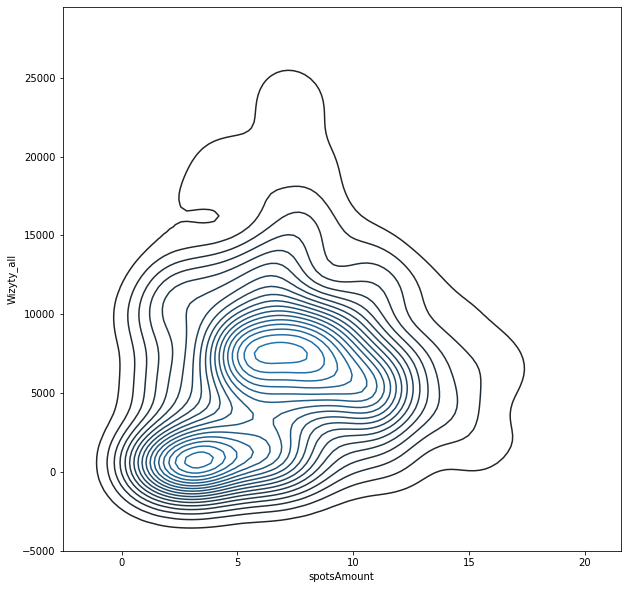

In [ ]:
fig = plt.figure(figsize=(10,10))
sns.kdeplot(dataset['spotsAmount'],dataset['Wizyty_all'],n_levels=20)

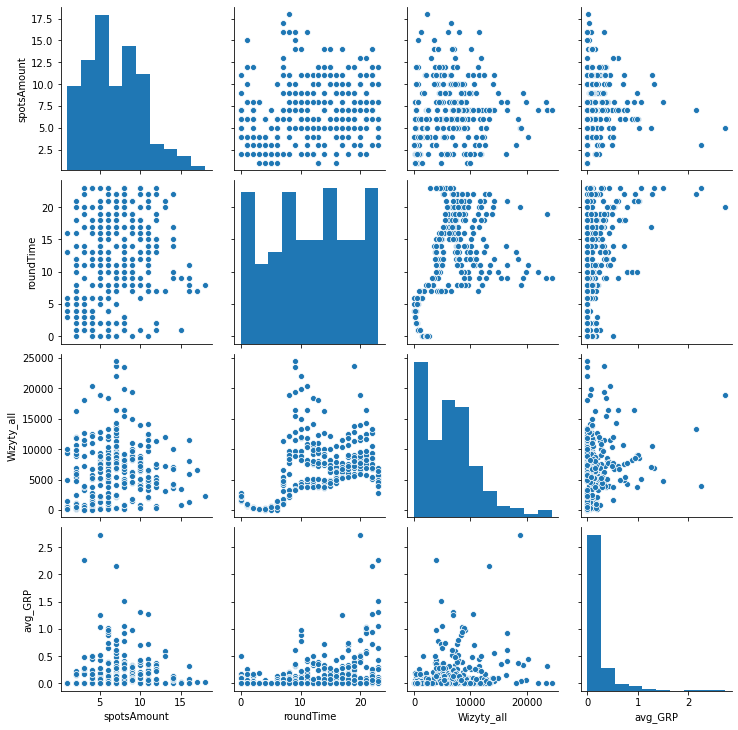

In [ ]:
sns.pairplot(dataset)

In [ ]:
dataset

,spotsAmount,roundTime,Wizyty_all,avg_GRP
DateTime,,,,
2014-11-10 06:00:00,4,6.0,1070,0.000000
2014-11-10 07:00:00,13,7.0,3086,0.000000
2014-11-10 08:00:00,16,8.0,5989,0.000000
2014-11-10 09:00:00,16,9.0,11506,0.325756
2014-11-10 10:00:00,11,10.0,9680,0.000000
...,...,...,...,...
2014-11-22 21:00:00,6,21.0,5699,0.000000
2014-11-22 22:00:00,11,22.0,5350,0.062157
2014-11-22 23:00:00,3,23.0,3989,2.264192


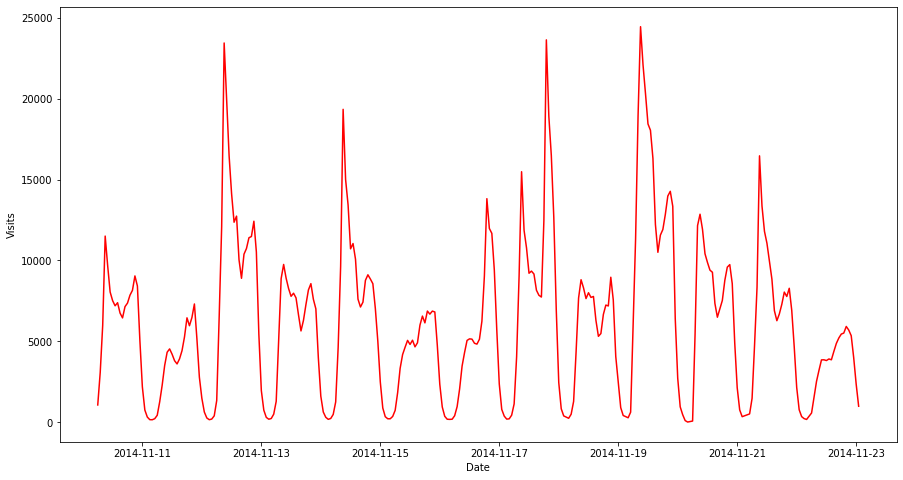

In [ ]:
fig = plt.figure(figsize = (15,8))

plt.xlabel('Date')
plt.ylabel('Visits')

plt.plot(dataset[['Wizyty_all']],color = 'red')

As we can see people tend to visit website more times during workdays.

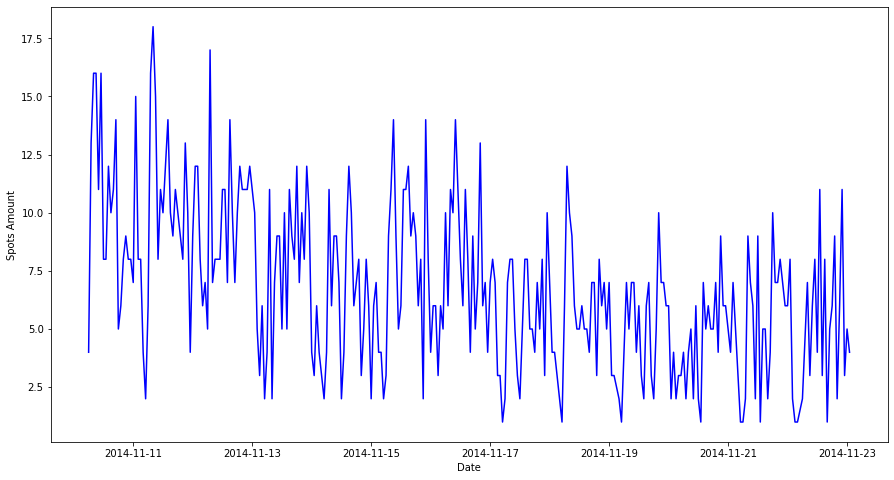

In [ ]:
fig = plt.figure(figsize = (15,8))

plt.xlabel('Date')
plt.ylabel('Spots Amount')

plt.plot(dataset[['spotsAmount']],color = 'blue')

In [ ]:
dataset.corr()

,spotsAmount,roundTime,Wizyty_all,avg_GRP
spotsAmount,1.000000,0.199981,0.124710,0.087090
roundTime,0.199981,1.000000,0.500102,0.400439
Wizyty_all,0.124710,0.500102,1.000000,0.223743
avg_GRP,0.087090,0.400439,0.223743,1.000000


#Data processing

##Correlation between spots amount on visits in general

In [ ]:
from scipy.stats import spearmanr

### For full dataset

Whether is any correlation between spots amount and visists on website in general

In [ ]:
whether = dataset[['spotsAmount','Wizyty_all']].reset_index(drop=True)
whether

,spotsAmount,Wizyty_all
0,4,1070
1,13,3086
2,16,5989
3,16,11506
4,11,9680
...,...,...
296,6,5699
297,11,5350
298,3,3989
299,5,2356


In [ ]:
print('Pearson\'s correlation index = ', 100*round(whether['spotsAmount'].corr(whether['Wizyty_all']),3),'%')
spearmanr(whether['spotsAmount'], whether['Wizyty_all'])

Pearson's correlation index =  12.5 %


SpearmanrResult(correlation=0.18834509636103747, pvalue=0.0010252509840333525)

In theory correlation between amount of spots and visits on website is additional, what means if spots amount rises visits on website also rises. Hovewer Pearson's and Spearman's correlation index's are so insignificant that we can't say that there is any linear correlation between both instances.

###For GRP greater than 0

whether is any correlation between viewed spots amount and visits on website? GRP stands for Gross Rating Point. The index presents potential audience of each spot. Since we've got a lot of spots with GRP 0.00 I will leave only those instances with GRP greater than 0.00.

In [ ]:
whether_grp = dataset[['spotsAmount', 'Wizyty_all', 'avg_GRP']]
whether_grp = whether_grp[whether_grp['avg_GRP']!=0]
whether_grp

,spotsAmount,Wizyty_all,avg_GRP
DateTime,,,
2014-11-10 09:00:00,16,11506,0.325756
2014-11-10 11:00:00,16,8049,0.073194
2014-11-10 12:00:00,8,7516,0.032165
2014-11-10 13:00:00,8,7198,0.082028
2014-11-10 14:00:00,12,7389,0.060103
...,...,...,...
2014-11-22 18:00:00,6,5451,0.751368
2014-11-22 19:00:00,9,5513,0.065635
2014-11-22 22:00:00,11,5350,0.062157


In [ ]:
whether_grp.corr()

,spotsAmount,Wizyty_all,avg_GRP
spotsAmount,1.000000,-0.051854,-0.143401
Wizyty_all,-0.051854,1.000000,0.178698
avg_GRP,-0.143401,0.178698,1.000000


In [ ]:
print('Pearson\'s correlation index = ', 100*round(whether_grp['spotsAmount'].corr(whether_grp['Wizyty_all']),3),'%')
spearmanr(whether['spotsAmount'], whether['Wizyty_all'])

Pearson's correlation index =  -5.2 %


SpearmanrResult(correlation=0.18834509636103747, pvalue=0.0010252509840333525)

The correlation index's are so small that we can't say that there is any correlation between two variables

##Separate dataset for weekdays and for weekends

In [ ]:
dataset

,spotsAmount,roundTime,Wizyty_all,avg_GRP
DateTime,,,,
2014-11-10 06:00:00,4,6.0,1070,0.000000
2014-11-10 07:00:00,13,7.0,3086,0.000000
2014-11-10 08:00:00,16,8.0,5989,0.000000
2014-11-10 09:00:00,16,9.0,11506,0.325756
2014-11-10 10:00:00,11,10.0,9680,0.000000
...,...,...,...,...
2014-11-22 21:00:00,6,21.0,5699,0.000000
2014-11-22 22:00:00,11,22.0,5350,0.062157
2014-11-22 23:00:00,3,23.0,3989,2.264192


In [ ]:
weekd_weeknd = dataset

In [ ]:
weekd_weeknd['DateTime'] = weekd_weeknd.index

In [ ]:
weekd_weeknd.reset_index(drop=True,inplace=True)

In [ ]:
weekd_weeknd

,spotsAmount,roundTime,Wizyty_all,avg_GRP,DateTime
0,4,6.0,1070,0.000000,2014-11-10 06:00:00
1,13,7.0,3086,0.000000,2014-11-10 07:00:00
2,16,8.0,5989,0.000000,2014-11-10 08:00:00
3,16,9.0,11506,0.325756,2014-11-10 09:00:00
4,11,10.0,9680,0.000000,2014-11-10 10:00:00
...,...,...,...,...,...
296,6,21.0,5699,0.000000,2014-11-22 21:00:00
297,11,22.0,5350,0.062157,2014-11-22 22:00:00
298,3,23.0,3989,2.264192,2014-11-22 23:00:00
299,5,0.0,2356,0.000000,2014-11-23 00:00:00


In [ ]:
weekd_weeknd['isWeekend'] = weekd_weeknd['DateTime'].apply(lambda x: 0 if x.weekday()<5 else 1)

In [ ]:
weekd_weeknd

,spotsAmount,roundTime,Wizyty_all,avg_GRP,DateTime,isWeekend
0,4,6.0,1070,0.000000,2014-11-10 06:00:00,0
1,13,7.0,3086,0.000000,2014-11-10 07:00:00,0
2,16,8.0,5989,0.000000,2014-11-10 08:00:00,0
3,16,9.0,11506,0.325756,2014-11-10 09:00:00,0
4,11,10.0,9680,0.000000,2014-11-10 10:00:00,0
...,...,...,...,...,...,...
296,6,21.0,5699,0.000000,2014-11-22 21:00:00,1
297,11,22.0,5350,0.062157,2014-11-22 22:00:00,1
298,3,23.0,3989,2.264192,2014-11-22 23:00:00,1
299,5,0.0,2356,0.000000,2014-11-23 00:00:00,1


In [ ]:
weekd = weekd_weeknd[weekd_weeknd['isWeekend'] == 0]
weeknd = weekd_weeknd[weekd_weeknd['isWeekend'] == 1]

###Correlation in weekdays

In [ ]:
weekd.corr()

,spotsAmount,roundTime,Wizyty_all,avg_GRP,isWeekend
spotsAmount,1.000000,0.179864,0.090511,0.092688,NaN
roundTime,0.179864,1.000000,0.468910,0.411254,NaN
Wizyty_all,0.090511,0.468910,1.000000,0.260921,NaN
avg_GRP,0.092688,0.411254,0.260921,1.000000,NaN
isWeekend,NaN,NaN,NaN,NaN,NaN


Insignifficant correlation between spots amount and visits

###Correlation in weekends

In [ ]:
weeknd

,spotsAmount,roundTime,Wizyty_all,avg_GRP,DateTime,isWeekend
114,2,0.0,2490,0.000000,2014-11-15 00:00:00,1
115,6,1.0,883,0.162133,2014-11-15 01:00:00,1
116,7,2.0,345,0.129395,2014-11-15 02:00:00,1
117,4,3.0,217,0.000000,2014-11-15 03:00:00,1
118,4,4.0,216,0.000000,2014-11-15 04:00:00,1
...,...,...,...,...,...,...
296,6,21.0,5699,0.000000,2014-11-22 21:00:00,1
297,11,22.0,5350,0.062157,2014-11-22 22:00:00,1
298,3,23.0,3989,2.264192,2014-11-22 23:00:00,1
299,5,0.0,2356,0.000000,2014-11-23 00:00:00,1


In [ ]:
weeknd.corr()

,spotsAmount,roundTime,Wizyty_all,avg_GRP,isWeekend
spotsAmount,1.000000,0.261625,0.327088,0.072807,NaN
roundTime,0.261625,1.000000,0.814086,0.374228,NaN
Wizyty_all,0.327088,0.814086,1.000000,0.165414,NaN
avg_GRP,0.072807,0.374228,0.165414,1.000000,NaN
isWeekend,NaN,NaN,NaN,NaN,NaN


Here in weekends we've got low positive correlation between spots amount and visits on website and high positive correlation between visits and time. Let's work on this data just a little bit more

####Scatterplot visits and spots

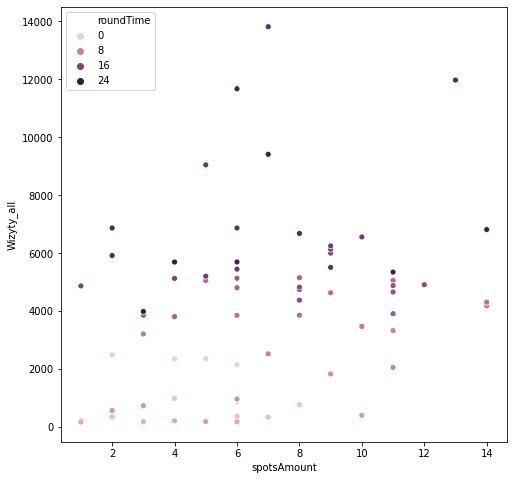

In [ ]:
fig = plt.figure(figsize = (8,8))

plt.xlabel('')
plt.ylabel('')

sns.scatterplot(data = weeknd, x=weeknd['spotsAmount'], y = weeknd['Wizyty_all'],hue='roundTime')

####Weekends dataset by hours

I will group by dataset by round time

In [ ]:
weeknd_grouped = weeknd[['spotsAmount','Wizyty_all','roundTime']]
weeknd_grouped = weeknd_grouped.groupby(by=['roundTime']).sum()
weeknd_grouped.reset_index(drop=True,inplace=True)
weeknd_grouped

,spotsAmount,Wizyty_all
0,17,9352
1,24,3595
2,15,1064
3,8,631
4,11,570
5,7,550
6,15,1717
7,15,2801
8,29,7920
9,27,10874


####Correlation

In [ ]:
print(weeknd_grouped['spotsAmount'].corr(weeknd_grouped['Wizyty_all']))
spearmanr(weeknd_grouped['spotsAmount'],weeknd_grouped['Wizyty_all'])

0.4635703535813985


SpearmanrResult(correlation=0.3517370914588508, pvalue=0.09188906427209022)

In [ ]:
weeknd_grouped.corr()

,spotsAmount,Wizyty_all
spotsAmount,1.00000,0.46357
Wizyty_all,0.46357,1.00000


####Scatterplot in grouped weeknd dataset

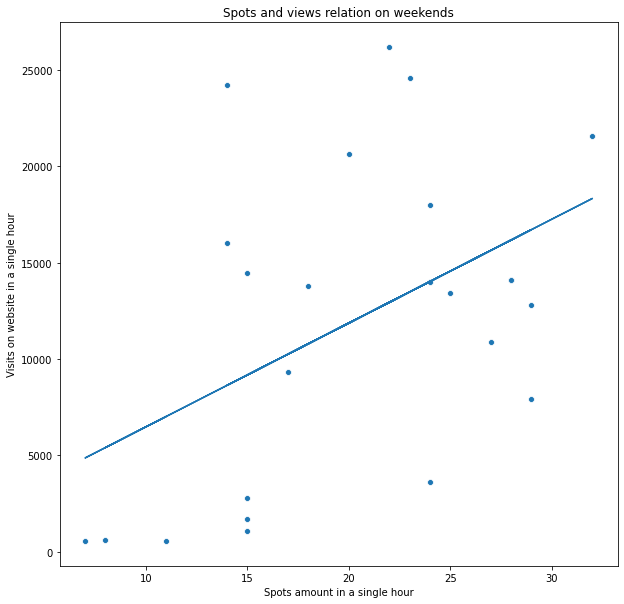

In [ ]:
fig = plt.figure(figsize = (10,10))

x = weeknd_grouped['spotsAmount']
y = weeknd_grouped['Wizyty_all']


m, b = np.polyfit(weeknd_grouped['spotsAmount'], weeknd_grouped['Wizyty_all'], 1)
plt.plot(x, m*x + b)

sns.scatterplot(data = weeknd_grouped, x='spotsAmount', y = 'Wizyty_all',)
plt.xlabel('Spots amount in a single hour')
plt.ylabel('Visits on website in a single hour')
plt.title('Spots and views relation on weekends')
plt.savefig('spots_vs_views_weekends')
plt.show()

As you can see, there is a significant tendency to increase the number of visitors as the number of spots on the weekend increases

####Simple Linear model for spots and visits

In [ ]:
spots_weeknd = pd.DataFrame(weeknd_grouped['spotsAmount'].values)
visits_weeknd = pd.DataFrame(weeknd_grouped['Wizyty_all'].values)

In [ ]:
spots_weeknd.rename(columns={0:'spotsAmount'}, inplace=True)

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(spots_weeknd,visits_weeknd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lm.coef_

array([[538.80520046]])

In [ ]:
cdf = pd.DataFrame(lm.coef_,spots_weeknd.columns,columns=['Coeff'])
cdf

,Coeff
spotsAmount,538.8052


In [ ]:
weeknd_grouped

,spotsAmount,Wizyty_all
0,17,9352
1,24,3595
2,15,1064
3,8,631
4,11,570
5,7,550
6,15,1717
7,15,2801
8,29,7920
9,27,10874


Increase amount of spots on weends by one unit is associated with increase of views on website by 534 views. Thus in weekends with higher amount of spots we can be ready for higher amount of visits on website.

####Multiple Linear Regression for spots, time and visits

In [ ]:
weeknd.corr()

,spotsAmount,roundTime,Wizyty_all,avg_GRP,isWeekend
spotsAmount,1.000000,0.261625,0.327088,0.072807,NaN
roundTime,0.261625,1.000000,0.814086,0.374228,NaN
Wizyty_all,0.327088,0.814086,1.000000,0.165414,NaN
avg_GRP,0.072807,0.374228,0.165414,1.000000,NaN
isWeekend,NaN,NaN,NaN,NaN,NaN


We have to be aware also that there is high correlation berween time and visits. 

In [ ]:
weeknd_rt_vis_spo = weeknd[['roundTime','spotsAmount','Wizyty_all']]

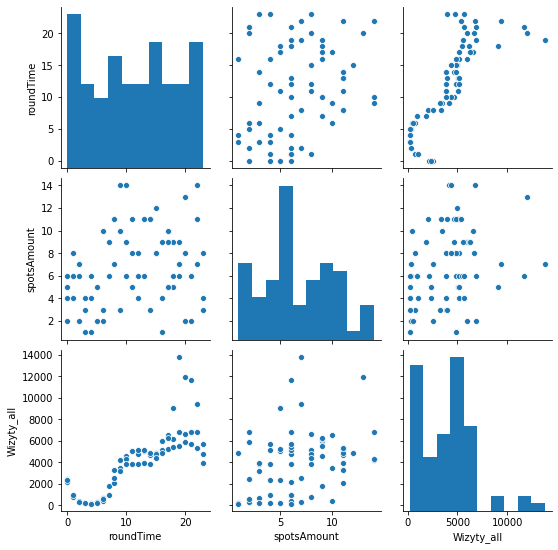

In [ ]:
sns.pairplot(weeknd_rt_vis_spo)

In [ ]:
lm2 = LinearRegression()
lm2.fit(weeknd_rt_vis_spo[['roundTime','spotsAmount']],weeknd_rt_vis_spo['Wizyty_all'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lm2.coef_

array([322.19859391, 105.99442303])

cdf = pd.DataFrame(lm.coef_,spots_weeknd.columns,columns=['Coeff'])
cdf


In [ ]:
cdf2 = pd.DataFrame(lm2.coef_,weeknd_rt_vis_spo.columns[:2],columns=['Coeff'])
cdf2

,Coeff
roundTime,322.198594
spotsAmount,105.994423


*   Increase of time by one hour on weekends Ceteris Paribus is associated with increase of visits amount by 322
*   Increase of spots amount by one on weekends Ceteris Paribus is associated with increase of visits amount by 106


#####Exemplary linear regression plot

Let's present this model in more suitable form

In [ ]:
dataset['spotsAmount'].max()

18

We had maximum of 18 spots displayed and minimum of 1 spots in a single hour. Let's create prediciton plot

In [ ]:
h = []
s = []
for i in range(1,25):
  h.append(i)
  s.append(i)

In [ ]:
d = {'time':h,'spots':s}
exmpl = pd.DataFrame(data = {'time':h,'spots':s})

In [ ]:
predictions = lm2.predict(exmpl)

In [ ]:
exmpl['predicted_views'] = predictions

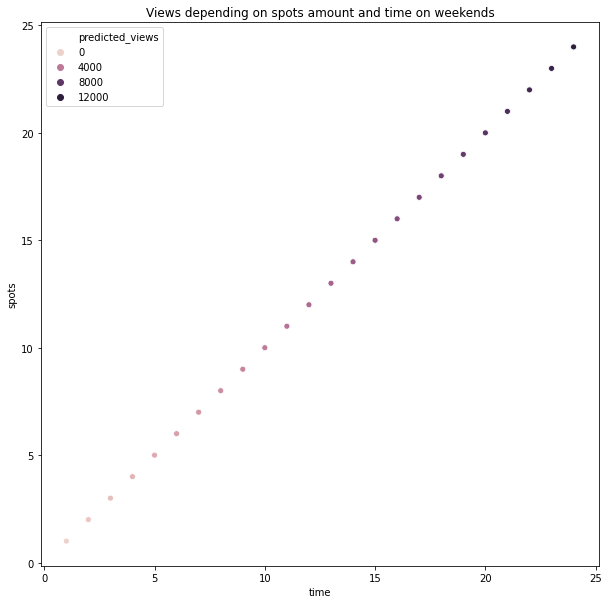

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.title('Views depending on spots amount and time on weekends')
plt.xlabel('Time')
plt.ylabel('Spots')
sns.scatterplot(x = exmpl['time'],y=exmpl['spots'],hue=exmpl['predicted_views'])
plt.savefig('views_spots_time.png')

Therefore if we want to optimize our spots distribution we should focus on displaying most views as late as it is possible on weekends. 

In [ ]:
d = {'time':23,'spots_no':20}
arr = pd.DataFrame(np.array([[23,20]]), columns = ['time','spots_on'])
prediction = lm2.predict(arr)

In [ ]:
print(prediction)

[9148.19845427]


As we can see at 23 p.m. on Saturday or Sunday with 20 spots displayed at that time our views amount should increase by 9148 views according to ours model

In [ ]:
max = dataset['Wizyty_all'].max()

###Correlation table for all variables on weekend (dummied)

In [ ]:
data

,Data,godzina,Wizyty_all,date_datetime,Campaign Channel,AGB Channel,Date,Time,Timeband,BreakType (Block type),Title,Position Type in the block of commercials,Commercial length,GRP,actualHour,dayOfMonth,roundTime,dateReassigned_datetime
0,2014-11-10,6,1070,2014-11-10 06:00:00,TVN Pakiet Tematyczny,FoxLife,2014-11-10,06:10:25,Day,Between,ZONA DLA MILIONERA /PROG.ROZR.USA/,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
1,2014-11-10,6,1070,2014-11-10 06:00:00,TVP Pakiet Tematyczny,TVP Seriale,2014-11-10,06:11:50,Day,After,LOKATORZY /SER.KOM.POL./,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
2,2014-11-10,6,1070,2014-11-10 06:00:00,TVN Pakiet Tematyczny,Mjuzik.tv,2014-11-10,06:12:59,Day,Between,TELEDYSKI,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
3,2014-11-10,6,1070,2014-11-10 06:00:00,TVN Pakiet Tematyczny,MTV Polska,2014-11-10,06:19:06,Day,Between,PIMP MY RIDE,Middle,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00
4,2014-11-10,7,3086,2014-11-10 07:00:00,TVN Pakiet Tematyczny,Comedy Central Family,2014-11-10,06:42:34,Day,Between,DALEKO JESZCZE? /SER.KOM.USA/,Middle,30.0,0.000000,6.0,10.0,7.0,2014-11-10 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,2014-11-23,0,2356,2014-11-23 00:00:00,TVN Pakiet Tematyczny,FoxLife,2014-11-23,23:47:53,Night,Before,POKOJOWKI Z BEVERLY HILLS /SER.OBYCZ.USA/,Middle,30.0,0.000000,23.0,23.0,0.0,2014-11-23 00:00:00
2066,2014-11-23,1,991,2014-11-23 01:00:00,Polsat Pakiet Tematyczny,Kino Polska,2014-11-22,00:31:57,Night,Between,07 ZGLOS SIE /SER.KRYM.POL./,Middle,30.0,0.000000,0.0,23.0,1.0,2014-11-23 01:00:00
2067,2014-11-23,1,991,2014-11-23 01:00:00,TVN Pakiet Tematyczny,TVN Style,2014-11-22,01:19:40,Night,Between,SEKS NA MILION SPOSOBOW /SER.DOK.FRA./,Middle,30.0,0.478713,1.0,23.0,1.0,2014-11-23 01:00:00
2068,2014-11-23,1,991,2014-11-23 01:00:00,TVN Pakiet Tematyczny,Domo,2014-11-22,01:24:35,Night,After,POUZYWAJMY SOBIE HISTORIA POLSKIEGO WZORNICTWA...,Middle,30.0,0.000000,1.0,23.0,1.0,2014-11-23 01:00:00


In [ ]:
data_dummies = pd.get_dummies(data)
data_dummies

,Data,godzina,Wizyty_all,date_datetime,Commercial length,GRP,actualHour,dayOfMonth,roundTime,dateReassigned_datetime,Campaign Channel_Polsat,Campaign Channel_Polsat Pakiet Tematyczny,Campaign Channel_TVN,Campaign Channel_TVN Pakiet Tematyczny,Campaign Channel_TVP Pakiet Tematyczny,Campaign Channel_TVP1,Campaign Channel_TVP2,AGB Channel_13th Street Universal,AGB Channel_ATM Rozrywka,AGB Channel_AXN,AGB Channel_AXN White,AGB Channel_Ale Kino,AGB Channel_Animal HD,AGB Channel_Animal Planet,AGB Channel_BBC Knowledge,AGB Channel_CBS Drama,AGB Channel_CBS Europa,AGB Channel_CBS Reality,AGB Channel_Comedy Central Family,AGB Channel_Disco Polo Music,AGB Channel_Domo,AGB Channel_E!Entertainment,AGB Channel_Extreme Sports,AGB Channel_FoxLife,AGB Channel_History,AGB Channel_Investigation Discovery,AGB Channel_Kino Polska,AGB Channel_Kino Polska Muzyka,AGB Channel_MTV Polska,AGB Channel_Mjuzik.tv,...,Title_ZAKLINACZ PSOW /DOK.W.BRYT./,Title_ZAKLINACZ WEZY /FILM DOK.AUSTRALIA/,Title_ZAKLINACZE KONI /SER.DRA.KAN./,Title_ZAKOCHANA ZLOSNICA /FILM KOM.USA/,Title_ZAKOCHANY ANIOL /FILM KOM.POL./,Title_ZALOGA G /FILM FAM.USA/,Title_ZAPISKI LAZEGI /REP.POL./,Title_ZAPOMNIANA MELODIA /FILM ARCH.POL./,Title_ZAPOMNIANE POWSTANIE /FILM DOK.POL./,Title_ZAPOMNIANY GENERAL TADEUSZ JORDAN ROZWADOWSKI /FILM DOK.POL./,Title_ZATOPIENI /FILM SENS.BULG.-W.BRYT/,Title_ZBRODNIE KTORE WSTRZASNELY AMERYKA /SER.DOK.USA/,Title_ZBRODNIE PALM GLADE /SER.SENS.USA/,Title_ZDOBYWCY KRABY KAMCZACKIE /SER.DOK.FR./,Title_ZE SMIERCIA JEJ DO TWARZY /FILM FAB.USA/,Title_ZE WSCHODU NA ZACHOD /FILM DOK.WIELK.BRYT./,Title_ZEMSTA /SER.OBYCZ.USA/,Title_ZIARNO /PROG.RELIG.DLA DZIECI/,Title_ZJAWISKA PARANORMALNE /SER.DOK.USA/,Title_ZLO W GENACH /SER.DOK.USA/,Title_ZLO W MOIM DOMU /SER.DOK.USA/,Title_ZLOTE PRZEBOJE /TELEDYSKI/,Title_ZLOTO DEZERTEROW /FILM KOM.POL./,Title_ZOLNIERSKA NUTA... /FILM DOK.POL./,Title_ZONA DLA MILIONERA /PROG.ROZR.USA/,Title_ZOO /SER.DOK.N.ZEL./,Title_ZROBMY SOBIE DOM /REALITY SHOW/,Title_ZROSNIETE BLIZNIAKI /FILM DOK.WIEL.BRYT./,Title_ZUS DLA CIEBIE /PROG.INFOR./,Title_ZWIAZKI INNE NIZ WSZYSTKIE /PROG.DOK.USA/,Title_ZWIERZECE LOVE STORY /SER.DOK W.BRYT./,Title_ZWIERZECY ARMAGEDDON /MINISER.DOK.USA/,Title_ZYCIE /SER.DOK.W.BRYT/,Title_ZYCIE BEZ WSTYDU /REALITY SHOW POL./,Title_ZYCIE MOJE SKRETAMI BIEZY /FILM DOK.POL./,Title_ZYCIE PISANE PODROZA /FILM DOK.POL./,Title_ZYCIE ZA ZYCIE /FILM DRAM.NIEM.USA/,Position Type in the block of commercials_First / Last,Position Type in the block of commercials_Middle,Position Type in the block of commercials_Second / Penultimate
0,2014-11-10,6,1070,2014-11-10 06:00:00,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2014-11-10,6,1070,2014-11-10 06:00:00,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2014-11-10,6,1070,2014-11-10 06:00:00,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2014-11-10,6,1070,2014-11-10 06:00:00,30.0,0.000000,6.0,10.0,6.0,2014-11-10 06:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2014-11-10,7,3086,2014-11-10 07:00:00,30.0,0.000000,6.0,10.0,7.0,2014-11-10 07:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
data_dummies_grouped = data_dummies.groupby(by='dateReassigned_datetime').sum().drop(['Wizyty_all','actualHour','godzina','GRP','dayOfMonth','roundTime'],axis=1) 

In [ ]:
data_dummies_grouped.reset_index(drop=True,inplace=True)

In [ ]:
data_dummies_grouped

,Commercial length,Campaign Channel_Polsat,Campaign Channel_Polsat Pakiet Tematyczny,Campaign Channel_TVN,Campaign Channel_TVN Pakiet Tematyczny,Campaign Channel_TVP Pakiet Tematyczny,Campaign Channel_TVP1,Campaign Channel_TVP2,AGB Channel_13th Street Universal,AGB Channel_ATM Rozrywka,AGB Channel_AXN,AGB Channel_AXN White,AGB Channel_Ale Kino,AGB Channel_Animal HD,AGB Channel_Animal Planet,AGB Channel_BBC Knowledge,AGB Channel_CBS Drama,AGB Channel_CBS Europa,AGB Channel_CBS Reality,AGB Channel_Comedy Central Family,AGB Channel_Disco Polo Music,AGB Channel_Domo,AGB Channel_E!Entertainment,AGB Channel_Extreme Sports,AGB Channel_FoxLife,AGB Channel_History,AGB Channel_Investigation Discovery,AGB Channel_Kino Polska,AGB Channel_Kino Polska Muzyka,AGB Channel_MTV Polska,AGB Channel_Mjuzik.tv,AGB Channel_Muzo. tv,AGB Channel_Polsat,AGB Channel_Polsat Cafe,AGB Channel_Polsat Crime & Investigation,AGB Channel_Polsat Film,AGB Channel_Polsat Food,AGB Channel_Polsat News,AGB Channel_Polsat News 2,AGB Channel_Polsat Romans,...,Title_ZAKLINACZ PSOW /DOK.W.BRYT./,Title_ZAKLINACZ WEZY /FILM DOK.AUSTRALIA/,Title_ZAKLINACZE KONI /SER.DRA.KAN./,Title_ZAKOCHANA ZLOSNICA /FILM KOM.USA/,Title_ZAKOCHANY ANIOL /FILM KOM.POL./,Title_ZALOGA G /FILM FAM.USA/,Title_ZAPISKI LAZEGI /REP.POL./,Title_ZAPOMNIANA MELODIA /FILM ARCH.POL./,Title_ZAPOMNIANE POWSTANIE /FILM DOK.POL./,Title_ZAPOMNIANY GENERAL TADEUSZ JORDAN ROZWADOWSKI /FILM DOK.POL./,Title_ZATOPIENI /FILM SENS.BULG.-W.BRYT/,Title_ZBRODNIE KTORE WSTRZASNELY AMERYKA /SER.DOK.USA/,Title_ZBRODNIE PALM GLADE /SER.SENS.USA/,Title_ZDOBYWCY KRABY KAMCZACKIE /SER.DOK.FR./,Title_ZE SMIERCIA JEJ DO TWARZY /FILM FAB.USA/,Title_ZE WSCHODU NA ZACHOD /FILM DOK.WIELK.BRYT./,Title_ZEMSTA /SER.OBYCZ.USA/,Title_ZIARNO /PROG.RELIG.DLA DZIECI/,Title_ZJAWISKA PARANORMALNE /SER.DOK.USA/,Title_ZLO W GENACH /SER.DOK.USA/,Title_ZLO W MOIM DOMU /SER.DOK.USA/,Title_ZLOTE PRZEBOJE /TELEDYSKI/,Title_ZLOTO DEZERTEROW /FILM KOM.POL./,Title_ZOLNIERSKA NUTA... /FILM DOK.POL./,Title_ZONA DLA MILIONERA /PROG.ROZR.USA/,Title_ZOO /SER.DOK.N.ZEL./,Title_ZROBMY SOBIE DOM /REALITY SHOW/,Title_ZROSNIETE BLIZNIAKI /FILM DOK.WIEL.BRYT./,Title_ZUS DLA CIEBIE /PROG.INFOR./,Title_ZWIAZKI INNE NIZ WSZYSTKIE /PROG.DOK.USA/,Title_ZWIERZECE LOVE STORY /SER.DOK W.BRYT./,Title_ZWIERZECY ARMAGEDDON /MINISER.DOK.USA/,Title_ZYCIE /SER.DOK.W.BRYT/,Title_ZYCIE BEZ WSTYDU /REALITY SHOW POL./,Title_ZYCIE MOJE SKRETAMI BIEZY /FILM DOK.POL./,Title_ZYCIE PISANE PODROZA /FILM DOK.POL./,Title_ZYCIE ZA ZYCIE /FILM DRAM.NIEM.USA/,Position Type in the block of commercials_First / Last,Position Type in the block of commercials_Middle,Position Type in the block of commercials_Second / Penultimate
0,120.0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
1,390.0,0,7,0,3,3,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,5
2,480.0,0,6,0,8,2,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,11,1
3,480.0,0,6,1,3,3,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,12,2
4,330.0,0,4,0,5,2,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,180.0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

In [ ]:
dataset_extended = dataset.join(data_dummies_grouped, lsuffix='values', rsuffix='dummies')
dataset_extended_wknd = dataset_extended[dataset_extended['isWeekend']==1]
dataset_extended_wkd = dataset_extended[dataset_extended['isWeekend']==0]

In [ ]:
dataset_extended_corr_wknd = dataset_extended_wknd.corr()
dataset_extended_corr_wkd = dataset_extended_wkd.corr()

####Correlation on weekdays

In [ ]:
df = pd.DataFrame(np.triu(dataset_extended_corr_wkd, 1), columns=dataset_extended_corr_wkd.columns, index=dataset_extended_corr_wkd.index)
corr6_wkd = df[df > 0.2].stack().reset_index()

In [ ]:
corr6_wkd[corr6_wkd.level_1.str.contains("Wizyty_all")]

,level_0,level_1,0
68,roundTime,Wizyty_all,0.46891


####Correlation on weekends

In [ ]:
df = pd.DataFrame(np.triu(dataset_extended_corr_wknd, 1), columns=dataset_extended_corr_wknd.columns, index=dataset_extended_corr_wknd.index)
corr6_wknd = df[df > 0.2].stack().reset_index()

In [ ]:
corr6_wknd[corr6_wknd.level_1.str.contains("Wizyty_all")]

,level_0,level_1,0
1,spotsAmount,Wizyty_all,0.327088
136,roundTime,Wizyty_all,0.814086


As we can see the only correlation between spots amount and visits occurs on weekends.

###To see final conclussions please refer to the presentation attached